💈 Développez un moteur de recommandation de films



## Preamble



### Imports



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
warnings.filterwarnings("ignore")
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from random import randint
import pickle

# Out[1]:

### Functions



In [1]:
# Display all
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

# Out[2]:

## Load Data



### Load Data



In [1]:
df = pd.read_csv('../data/processed/movie_metadata_processed.csv')

# Out[4]:

### Glimpse at the data



In [1]:
display_all(df.describe(include='all').T)

# Out[5]:
|                           |   count |   unique | top              |   freq |            mean |              std |     min |           25% |             50% |             75% |              max |
|---------------------------+---------+----------+------------------+--------+-----------------+------------------+---------+---------------+-----------------+-----------------+------------------|
| Unnamed: 0                |    4688 |      nan | nan              |    nan |  2343.5         |   1353.45        |    0    | 1171.75       |  2343.5         |  3515.25        |   4687           |
| id                        |    4688 |     4688 | tt0006864        |      1 |   nan           |    nan           |  nan    |  nan          |   nan           |   nan           |    nan           |
| color                     |    4673 |        2 | Color            |   4477 |   nan           |    nan           |  nan    |  nan          |   nan           |   nan           |    nan           |
| dir

In [1]:
numerical = df.select_dtypes(include='number').columns
categorical = df.select_dtypes(exclude='number').columns

print(f"categorical columns are : {', '.join(str(x) for x in categorical)}")
print(f"numerical columns are : {', '.join(str(x) for x in numerical)}")

categorical columns are : id, color, director_name, actor_2_name, actor_1_name, movie_title, actor_3_name, plot_keywords, language, country, content_rating
numerical columns are : Unnamed: 0, actor_3_facebook_likes, actor_1_facebook_likes, title_year, actor_2_facebook_likes, aspect_ratio, Action, Adventure, Animation, Biography, Comedy, Crime, Documentary, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, News, Romance, Sci-Fi, Short, Sport, Thriller, War, Western, num_critic_for_reviews, duration, gross, director_facebook_likes, num_voted_users, cast_total_facebook_likes, facenumber_in_poster, num_user_for_reviews, budget, imdb_score, movie_facebook_likes

categorical columns are : color, director<sub>name</sub>, actor<sub>2</sub><sub>name</sub>, genres,
actor<sub>1</sub><sub>name</sub>, movie<sub>title</sub>, actor<sub>3</sub><sub>name</sub>, plot<sub>keywords</sub>, movie<sub>imdb</sub><sub>link</sub>,
language, country, content<sub>rating</sub>

numerical columns are : num<sub>critic</sub><sub>for</sub><sub>reviews</sub>, duration,
director<sub>facebook</sub><sub>likes</sub>, actor<sub>3</sub><sub>facebook</sub><sub>likes</sub>, actor<sub>1</sub><sub>facebook</sub><sub>likes</sub>, gross,
num<sub>voted</sub><sub>users</sub>, cast<sub>total</sub><sub>facebook</sub><sub>likes</sub>, facenumber<sub>in</sub><sub>poster</sub>,
num<sub>user</sub><sub>for</sub><sub>reviews</sub>, budget, title<sub>year</sub>, actor<sub>2</sub><sub>facebook</sub><sub>likes</sub>, imdb<sub>score</sub>,
aspect<sub>ratio</sub>, movie<sub>facebook</sub><sub>likes</sub>



### Posters



In [1]:
print(os.getcwd())
#os.chdir('./mauviette/notebooks')

# Out[31]:

In [1]:
img_path = '../data/external/posters/'
p = r"../data/processed/poster_features.pkl"

# Out[21]:

In [1]:
posters = []

# creates a ScandirIterator aliased as files
with os.scandir(img_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the posters list
            posters.append(file.name)

# Out[49]:

### Glimpse at a poster



In [1]:
# load the image as a 224x224 array
img = load_img(f'{img_path}/{posters[0]}', target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

# Out[34]:

In [1]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

# Out[35]:

In [1]:
x = preprocess_input(reshaped_img)

# Out[36]:

## Clustering



### Extracting features



Nous pouvons maintenant charger le modèle VGG et supprimer la couche de sortie
manuellement. Cela signifie que la nouvelle couche finale est une couche
entièrement connectée avec 4 096 nœuds de sortie. Ce vecteur de 4 096 nombres
est le vecteur de caractéristiques que nous utiliserons pour regrouper les
images.



In [1]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Out[5]:

In [1]:
features = model.predict(x, use_multiprocessing=True)

# Out[38]:

In [1]:
print(features.shape)
features

# Out[39]:
#+BEGIN_EXAMPLE
  array([[1.5461166 , 6.260435  , 2.117587  , ..., 0.        , 0.5195822 ,
  0.69436365]], dtype=float32)
#+END_EXAMPLE

-   Nous résumons l'ensemble du prototype ci-dessus en une fonction :



In [1]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# Out[40]:

-   Nous appliquons cette fonction à toutes nos affiches :



In [1]:
data = {}
counter = 0

# loop through each image in the dataset
for poster in posters:
    counter += 1
    print(f'{counter} : Extrating features for {poster}')
    feat = extract_features(f'{img_path}/{poster}', model)
    data[poster] = feat

# Out[50]:

In [1]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# Out[15]:

### Serializing features



In [1]:
with open(p,'wb') as file:
            pickle.dump(data, file)

# Out[54]:

In [1]:
with open(p, 'rb') as file:
    data = pickle.load(file)

# Out[7]:

-   get a list of just the features



In [1]:
feat = np.array(list(data.values()))
feat.shape

# Out[8]:
(4917, 1, 4096)

In [1]:
feat = feat.reshape(-1,4096)
feat.shape

# Out[9]:
(4917, 4096)

### Reduce dimension



In [1]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# Out[10]:

### Clustering K-Means



In [1]:
sse = []
list_k = list(range(50, 500))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    print(f'{k} clusters')
    sse.append(km.inertia_)

# Out[25]:

# Out[26]:

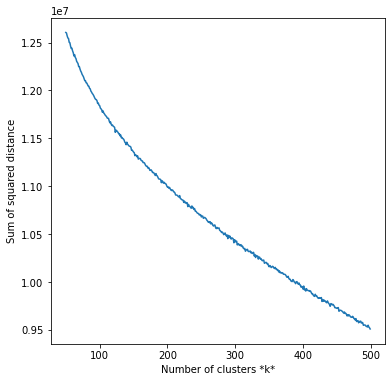

In [1]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [1]:
kmeans = KMeans(n_clusters=200, random_state=22)
kmeans.fit(x)

# Out[32]:
KMeans(n_clusters=200, random_state=22)

In [1]:
kmeans.labels_

# Out[13]:
array([85, 52, 99, ..., 69, 70, 85], dtype=int32)

In [1]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# Out[33]:

### Glimpse at the clusters



# Out[34]:

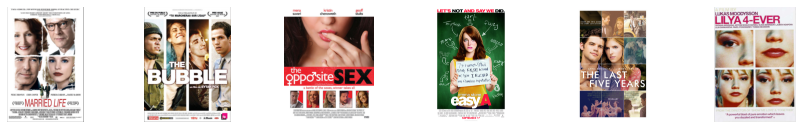

In [1]:
# function that lets view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(f'{img_path}/{file}')
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        

view_cluster(105)

## Bibliography



### References:PROPERTIES:




[../references/recsys.bib](../references/recsys.bib)

